In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [4]:
import pulse_compiler_helper_fns

In [5]:
q.IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [6]:
provider = q.IBMQ.get_provider(group='open')
backend = provider.get_backend('ibmq_armonk')
defaults = backend.defaults()
circ_inst_map = defaults.circuit_instruction_map
measure = circ_inst_map.get('measure', qubits=backend.configuration().meas_map[0])

## RB Schedules

In [77]:
from qiskit.transpiler.passes.optimize_1q_gates import Optimize1qGates

num_repetitions = 5
K = 25

schedules_std = {i: [] for i in range(num_repetitions)}
schedules_opt = {i: [] for i in range(num_repetitions)}
schedules_opt_slow = {i: [] for i in range(num_repetitions)}

for i in range(num_repetitions):
    for k in range(1, K):
        circuit, slow_circuit = q.QuantumCircuit(1), q.QuantumCircuit(1)

        total_theta, total_phi, total_lam = 0, 0, 0

        for _ in range(k):
            theta, phi, lam = np.random.rand() * np.pi, np.random.rand() * np.pi, np.random.rand() * np.pi
            circuit.u3(theta, phi, lam, 0); slow_circuit.u3(theta, phi, lam, 0); slow_circuit.iden(0);
            total_theta, total_phi, total_lam = Optimize1qGates.compose_u3(
                theta, phi, lam, total_theta, total_phi, total_lam)
        circuit.u3(-total_theta, -total_lam, -total_phi, 0)  # inverse of U3(theta, phi, lam) is U3(-theta, -lam, -phi)
        slow_circuit.u3(-total_theta, -total_lam, -total_phi, 0); slow_circuit.iden(0);


        transpiled_circuit = q.transpile(circuit, backend, optimization_level=0)
        schedule = q.schedule(transpiled_circuit, backend=backend, inst_map=circ_inst_map)
        schedule |= measure << schedule.duration
        schedules_std[i].append(schedule)

        with qiskit.PulseBackedOptimizationContext():
            decomposed_circuit = circuit.decompose()
            pulse_compiler_helper_fns.update_basis_gates_and_circ_inst_map(decomposed_circuit, backend, circ_inst_map)
            transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=0)
            schedule = q.schedule(transpiled_circuit, backend=backend, inst_map=circ_inst_map)
            schedule |= measure << schedule.duration
            schedules_opt[i].append(schedule)

            decomposed_circuit = slow_circuit.decompose()
            pulse_compiler_helper_fns.update_basis_gates_and_circ_inst_map(decomposed_circuit, backend, circ_inst_map)
            transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=0)
            schedule = q.schedule(transpiled_circuit, backend=backend, inst_map=circ_inst_map)
            schedule |= measure << schedule.duration
            schedules_opt_slow[i].append(schedule)

In [78]:
# ACTUALLY, HAD TO RUN THESE ONE BY ONE SINCE ARMONK ONLY ALLOWED 5 JOBS SUBMITTED AT A TIME
jobs_std, jobs_opt, jobs_opt_slow = {}, {}, {}
for i in range(num_repetitions):
    jobs_std[i] = q.execute(schedules_std[i], backend=backend, shots=8000)
    jobs_opt[i] = q.execute(schedules_opt[i], backend=backend, shots=8000)
    jobs_opt_slow[i] = q.execute(schedules_opt_slow[i], backend=backend, shots=8000)

In [82]:
job_ids_std = {0: '5e3cef4358ee6900185e84fa', 1: '5e3cf2f422883900183976fa', 2: '5e3cf5ea0c75be001886e554', 3: '5e3d8c3394f62b0018e1aa3f', 4: '5e3da65cb0bc3100191f8d96'}
job_ids_opt = {0: '5e3cef528baf3a001859d7d6', 1: '5e3cf2fe58ee6900185e84fd', 2: '5e3cf5f58baf3a001859d7da', 3: '5e3d8c3d4d0f01001837ede2', 4: '5e3da666a400ea001906bc38'}
job_ids_opt_slow = {0: '5e3cef7dd30b5c00189c9c71', 1: '5e3cf329d30b5c00189c9c74', 2: '5e3cf621e1620b0018c67f8f', 3: '5e3d8c48e92f620018c19c61', 4: '5e3da67223227b001859417b'}

In [83]:
jobs_std = {i: backend.retrieve_job(job_id) for (i, job_id) in job_ids_std.items()}
jobs_opt = {i: backend.retrieve_job(job_id) for (i, job_id) in job_ids_opt.items()}
jobs_opt_slow = {i: backend.retrieve_job(job_id) for (i, job_id) in job_ids_opt_slow.items()}

In [86]:
std_probs = [0] * (K-1)
opt_probs = [0] * (K-1)
opt_slow_probs = [0] * (K-1)

for i in range(num_repetitions):
    job_std, job_opt, job_opt_slow = jobs_std[i], jobs_opt[i], jobs_opt_slow[i]

    std_result, opt_result, opt_slow_result  = job_std.result(), job_opt.result(), job_opt_slow.result()

    for expt_num in range(K-1):
        std_probs[expt_num] += std_result.get_counts(expt_num).get('0', 0) / 8000 / num_repetitions
        opt_probs[expt_num] += opt_result.get_counts(expt_num).get('0', 0) / 8000 / num_repetitions
        opt_slow_probs[expt_num] += opt_slow_result.get_counts(expt_num).get('0', 0) / 8000 / num_repetitions

In [165]:
# Fit all three probabilities to alpha**k - A, with common A and different alpha's

def comboFunc(comboData, A, alpha_std, alpha_opt, alpha_opt_slow):  # https://stats.stackexchange.com/a/348874
    extract1 = comboData[:len(Ks)] # first data
    extract2 = comboData[len(Ks):-len(Ks)] # second data
    extract3 = comboData[-len(Ks):] # second data

    result1 = alpha_std**extract1 - A
    result2 = alpha_opt**extract2 - A
    result3 = alpha_opt_slow**extract3 - A

    return np.append(np.append(result1, result2), result3)


popt, _ = scipy.optimize.curve_fit(
    comboFunc,
    np.append(np.append(Ks, Ks), Ks),
    np.append(np.append(std_probs, opt_probs), opt_slow_probs),
    p0=[-0.03, 0.99, 0.99, 0.99])

A, alpha_std, alpha_opt, alpha_opt_slow = popt

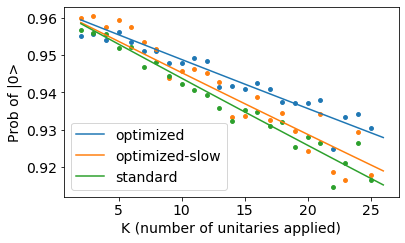

In [232]:
import scipy

plt.rcParams.update({'font.size': 14})

Ks = list(range(2, K+1))

fig, ax = plt.subplots(figsize=(6, 3.5))

plt.scatter(Ks, opt_probs, s=15)
plt.plot(np.linspace(2, K+1, 100), alpha_opt**np.linspace(2, K+1, 100) - A, label='optimized')

plt.scatter(Ks, opt_slow_probs, s=15)
plt.plot(np.linspace(2, K+1, 100), alpha_opt_slow**np.linspace(2, K+1, 100) - A, label='optimized-slow')

plt.scatter(Ks, std_probs, s=15)
plt.plot(np.linspace(2, K+1, 100), alpha_std**np.linspace(2, K+1, 100) - A, label='standard')


plt.xticks([5, 10, 15, 20, K]);
plt.legend()
plt.ylim(0.912, 0.963)
plt.ylabel('Prob of |0>');
plt.xlabel('K (number of unitaries applied)');
plt.savefig('Figures/RB.svg', bbox_inches = "tight")

In [223]:
np.array([alpha_opt, alpha_opt_slow, alpha_std]) * 100

array([99.86618157, 99.83044874, 99.8153452 ])

In [200]:
def coherence_limit(gatelen, T1, T2):  # from qiskit/ignis/verification/randomized_benchmarking/rb_utils.py
    return 0.5* (1.-2./3.*np.exp(-gatelen/T2) - 1./3.*np.exp(-gatelen/T1))

In [229]:
# all times below are in microseconds

# std takes 1280 dts per gate, each of 0.22 ns. Opt takes 640 dts per gate
gate_time_std = 1280*2.2222222222222221e-10 / 10e-6
gate_time_opt = 640*2.2222222222222221e-10 / 10e-6

print(coherence_limit(gate_time_std, T1=124, T2=102) * 100)
print(coherence_limit(gate_time_opt, T1=124, T2=102) * 100)

0.013117013635560726
0.006558940413795011
